***
# Starting Kit - Black Swan HiggsML Course
***

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    ! git clone https://github.com/blackSwanCS/Collaboration_D 
    %cd Collaboration_D

# HiggsML utility package should not be modified
%pip install HiggsML
    

Note: you may need to restart the kernel to use updated packages.


### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": False, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "w_scale": False, # W boson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 10 , # Number of pseudo-experiments to run per set
"num_of_sets" : 2, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "sample_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
test_settings = TEST_SETTINGS.copy()

if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is d:\Users\Hugo\SynologyDrive\CentraleSupelec\1A\cours\ST4-BlackSwan\EI-BDT\Git\Collaboration_D



### Add directories to path

In [6]:
path.append(submission_dir)

In [7]:
import HiggsML.visualization as visualization

## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


In [8]:
from model import Model

## Data

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from HiggsML.datasets import BlackSwan_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [ ]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090511 entries, 0 to 5090510
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 310.7 MB
None
[*] Train data loaded successfully


In [ ]:
# load test sets
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [ ]:
train_visualize = visualization.Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "PRI_lep_phi",
        "PRI_had_eta",
    ],
    name="Train Set",
)

In [ ]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 5090511
[*] --- Number of features : 16
   diboson   40590.00000000001
   htautau   3639.000000000001
   ttbar   158761.0
   ztautau   3544018.9999999986
[*] --- Number of signal events : 4233398
[*] --- Number of background events : 857113
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi
0,33.716999,-0.009,-1.614,42.567001,0.391,1.512,42.567001,0.391,1.512,-7.000000,-7.000,-7.000,-7.0,42.567001,18.089001,-2.276
1,39.069000,-0.382,2.876,45.743000,0.369,-0.165,45.743000,0.369,-0.165,-7.000000,-7.000,-7.000,-7.0,45.743000,11.859000,0.983
2,26.211000,0.736,-2.294,43.819000,0.565,0.889,43.819000,0.565,0.889,-7.000000,-7.000,-7.000,-7.0,43.819000,8.625000,-0.087
3,55.631001,-0.277,1.425,46.077999,0.190,-1.295,49.319000,1.085,3.036,46.077999,0.190,-1.295,-1.0,95.397003,33.098999,-0.798
4,96.626999,0.548,2.112,64.114998,-2.041,-2.114,64.114998,-2.041,-2.114,24.503000,-0.549,-0.182,1.0,88.617996,36.653000,0.112


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi
count,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06
mean,4.003698e+01,3.925515e-04,1.407315e-03,5.060483e+01,-2.050461e-04,4.544730e-05,7.441782e+01,-4.562408e-04,-4.969829e-04,3.285685e+01,-2.396049e+00,-2.394187e+00,-2.390822e+00,1.354049e+02,3.529635e+01,4.293358e-04
std,2.391789e+01,1.173680e+00,1.813465e+00,2.758823e+01,1.203902e+00,1.813313e+00,5.838737e+01,1.548441e+00,1.812562e+00,4.031430e+01,3.648030e+00,3.630997e+00,3.432632e+00,1.260542e+02,3.613746e+01,1.812714e+00
min,2.000000e+01,-2.500000e+00,-3.142000e+00,2.285000e+01,-2.688000e+00,-3.142000e+00,2.287800e+01,-4.962000e+00,-3.142000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-9.000000e+00,2.287800e+01,4.000000e-03,-3.142000e+00
25%,2.583500e+01,-8.910000e-01,-1.569000e+00,3.388800e+01,-9.250000e-01,-1.570000e+00,4.107000e+01,-1.115000e+00,-1.572000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,5.102600e+01,1.367400e+01,-1.570000e+00
50%,3.331800e+01,0.000000e+00,2.000000e-03,4.432600e+01,-1.000000e-03,0.000000e+00,5.537100e+01,-2.000000e-03,-1.000000e-03,3.107700e+01,-1.369000e+00,-1.631000e+00,-1.000000e+00,9.083600e+01,2.441600e+01,0.000000e+00
75%,4.544000e+01,8.930000e-01,1.573000e+00,5.823900e+01,9.250000e-01,1.570000e+00,8.354200e+01,1.114000e+00,1.570000e+00,5.053000e+01,5.960000e-01,7.760000e-01,0.000000e+00,1.761230e+02,4.313200e+01,1.571000e+00
max,1.261630e+03,2.500000e+00,3.142000e+00,1.260630e+03,2.728000e+00,3.142000e+00,1.509400e+03,4.962000e+00,3.142000e+00,1.276360e+03,4.998000e+00,3.142000e+00,1.000000e+01,3.542470e+03,1.242130e+03,3.142000e+00


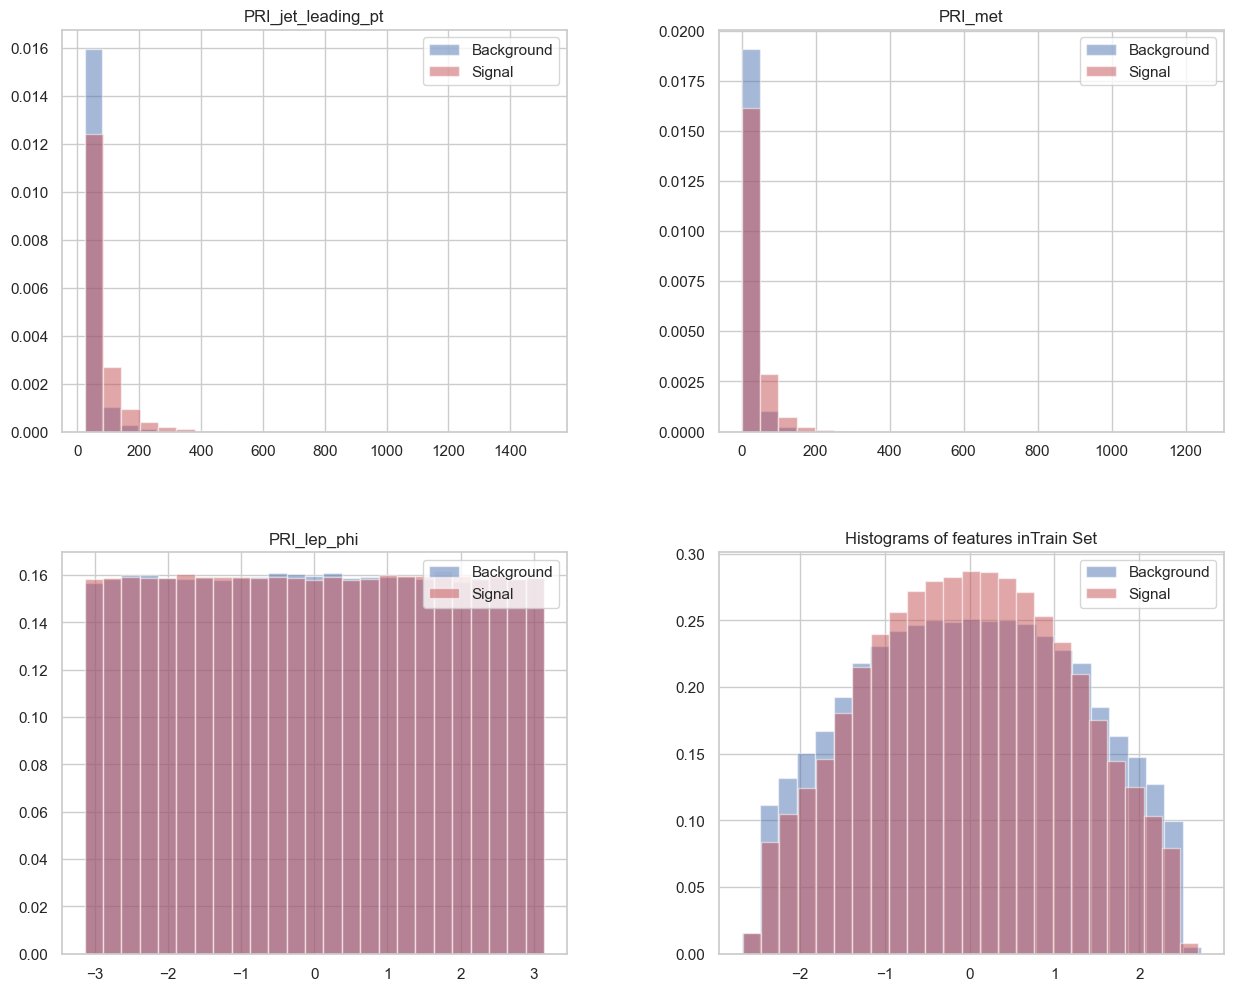

In [ ]:
# Show data summary
train_visualize.histogram_dataset()

diboson (147729,)
diboson (147729,)
htautau (30,)
ttbar (189157,)
ttbar (189157,)
ztautau (520227,)
ztautau (520227,)


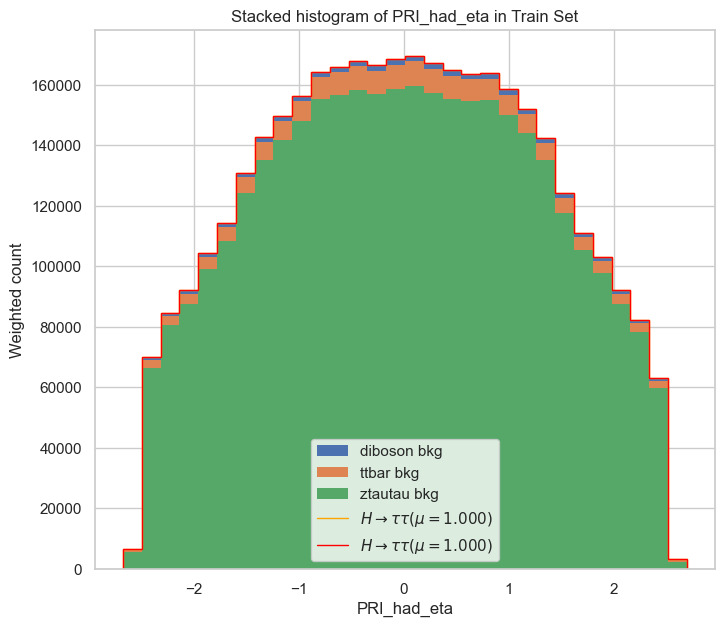

In [ ]:
train_visualize.stacked_histogram("PRI_had_eta")

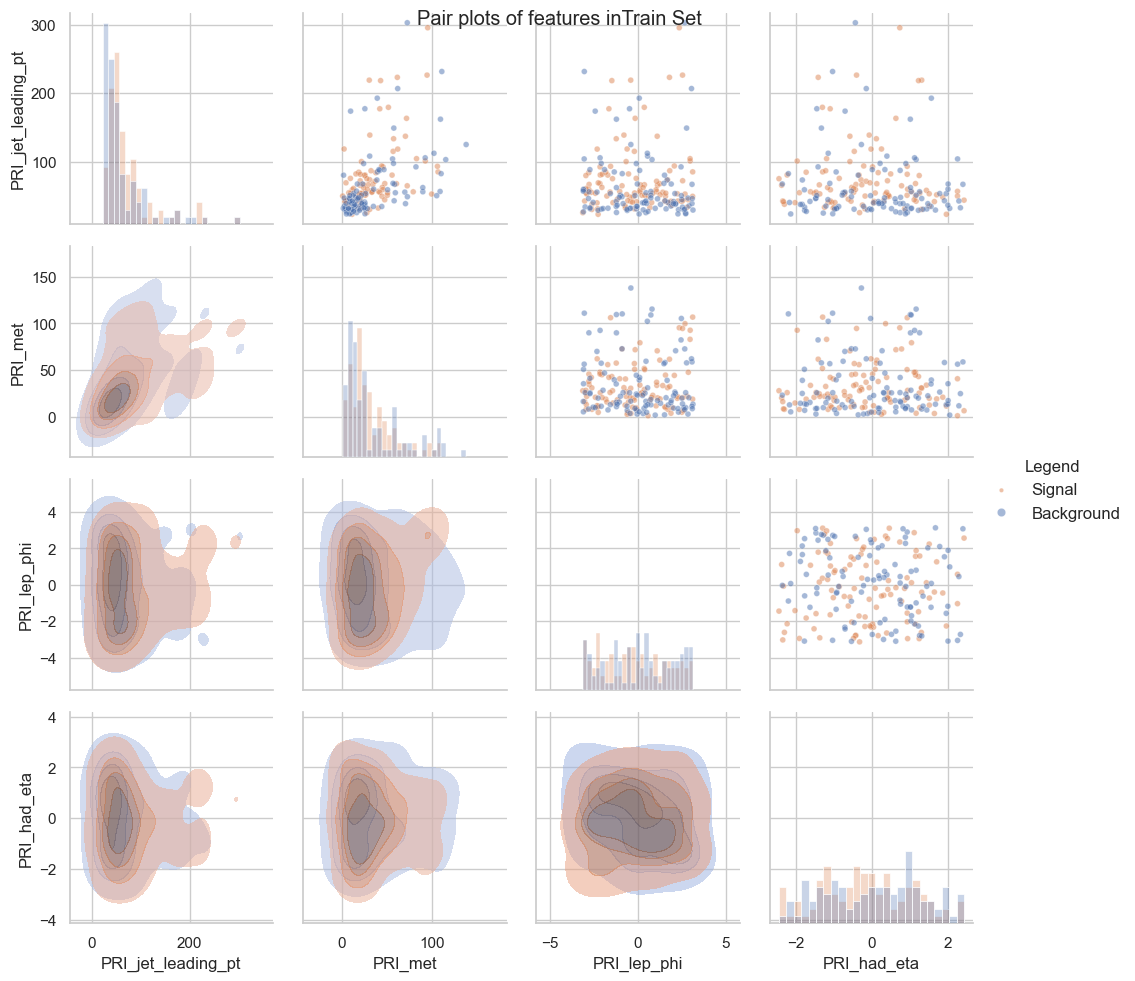

In [ ]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [ ]:
syst_train_data = data.get_syst_train_set()

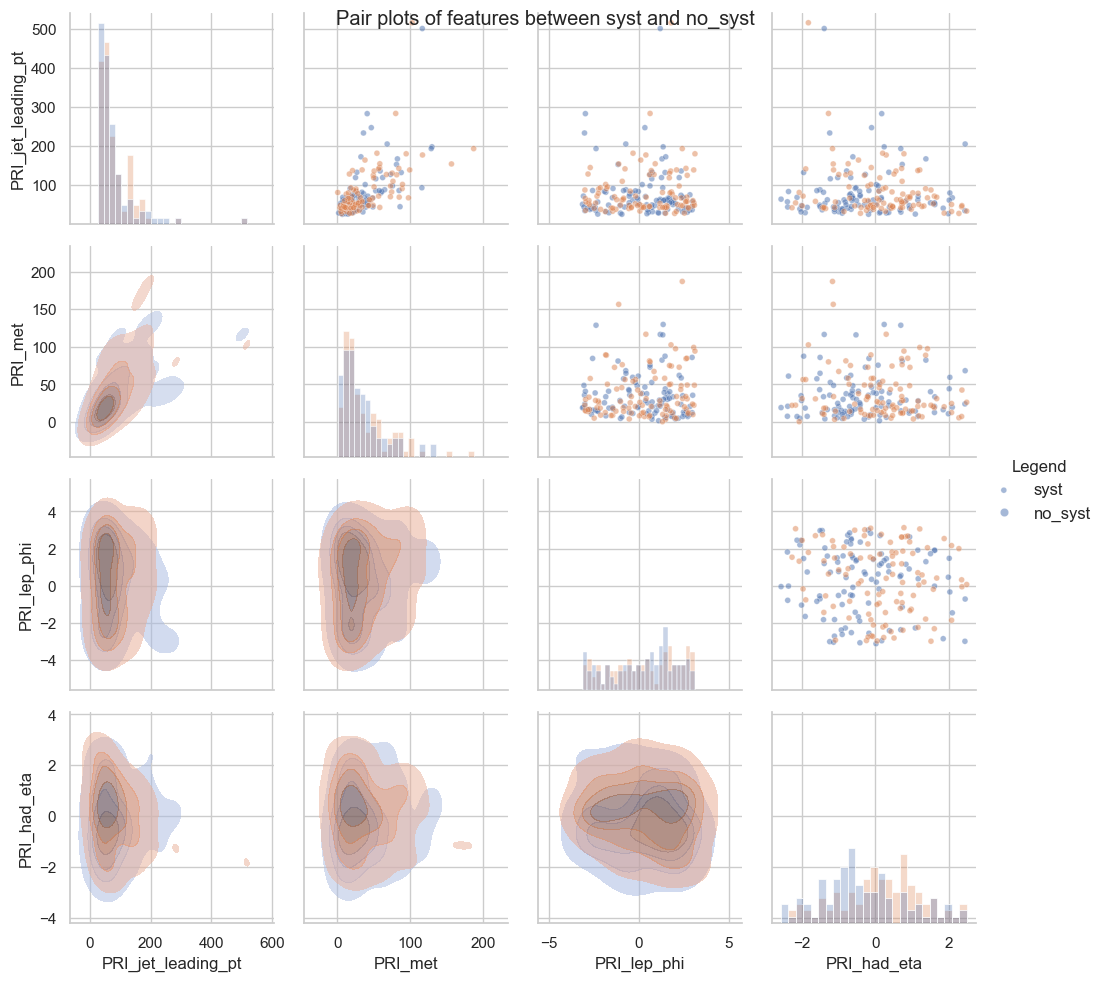

In [ ]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [ ]:
bootstraped_data = data.generate_psuedo_exp_data()

In [ ]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 5090511
[*] --- Number of features : 16
   diboson   40590.00000000001
   htautau   3639.000000000001
   ttbar   158761.0
   ztautau   3544018.9999999986
[*] --- Number of signal events : 4233398
[*] --- Number of background events : 857113
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi
0,33.716999,-0.009,-1.614,42.567001,0.391,1.512,42.567001,0.391,1.512,-7.000000,-7.000,-7.000,-7.0,42.567001,18.089001,-2.276
1,39.069000,-0.382,2.876,45.743000,0.369,-0.165,45.743000,0.369,-0.165,-7.000000,-7.000,-7.000,-7.0,45.743000,11.859000,0.983
2,26.211000,0.736,-2.294,43.819000,0.565,0.889,43.819000,0.565,0.889,-7.000000,-7.000,-7.000,-7.0,43.819000,8.625000,-0.087
3,55.631001,-0.277,1.425,46.077999,0.190,-1.295,49.319000,1.085,3.036,46.077999,0.190,-1.295,-1.0,95.397003,33.098999,-0.798
4,96.626999,0.548,2.112,64.114998,-2.041,-2.114,64.114998,-2.041,-2.114,24.503000,-0.549,-0.182,1.0,88.617996,36.653000,0.112


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi
count,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06,5.090511e+06
mean,4.003698e+01,3.925515e-04,1.407315e-03,5.060483e+01,-2.050461e-04,4.544730e-05,7.441782e+01,-4.562408e-04,-4.969829e-04,3.285685e+01,-2.396049e+00,-2.394187e+00,-2.390822e+00,1.354049e+02,3.529635e+01,4.293358e-04
std,2.391789e+01,1.173680e+00,1.813465e+00,2.758823e+01,1.203902e+00,1.813313e+00,5.838737e+01,1.548441e+00,1.812562e+00,4.031430e+01,3.648030e+00,3.630997e+00,3.432632e+00,1.260542e+02,3.613746e+01,1.812714e+00
min,2.000000e+01,-2.500000e+00,-3.142000e+00,2.285000e+01,-2.688000e+00,-3.142000e+00,2.287800e+01,-4.962000e+00,-3.142000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-9.000000e+00,2.287800e+01,4.000000e-03,-3.142000e+00
25%,2.583500e+01,-8.910000e-01,-1.569000e+00,3.388800e+01,-9.250000e-01,-1.570000e+00,4.107000e+01,-1.115000e+00,-1.572000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,5.102600e+01,1.367400e+01,-1.570000e+00
50%,3.331800e+01,0.000000e+00,2.000000e-03,4.432600e+01,-1.000000e-03,0.000000e+00,5.537100e+01,-2.000000e-03,-1.000000e-03,3.107700e+01,-1.369000e+00,-1.631000e+00,-1.000000e+00,9.083600e+01,2.441600e+01,0.000000e+00
75%,4.544000e+01,8.930000e-01,1.573000e+00,5.823900e+01,9.250000e-01,1.570000e+00,8.354200e+01,1.114000e+00,1.570000e+00,5.053000e+01,5.960000e-01,7.760000e-01,0.000000e+00,1.761230e+02,4.313200e+01,1.571000e+00
max,1.261630e+03,2.500000e+00,3.142000e+00,1.260630e+03,2.728000e+00,3.142000e+00,1.509400e+03,4.962000e+00,3.142000e+00,1.276360e+03,4.998000e+00,3.142000e+00,1.000000e+01,3.542470e+03,1.242130e+03,3.142000e+00


### Ingestion



In [ ]:

from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)


In [ ]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090511 entries, 0 to 5090510
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 310.7 MB
None
[*] Train data loaded successfully
Full data:  (5090511, 16)
Full Labels:  (5090511,)
Full Weights:  (5090511,)
sum_signal_weights:  3639.000000000001
sum_bkg_weights:  3743369.999999998
 
 
Training Data:  (3770937, 16)
Training Labels:  (3770937,)
Training Weights:  (3770937,)
sum_signal_weights:  3639.0000000000005
sum_bkg_weights:  3743369.9999999935

Valid Data:  (1527153, 16)
Valid Labels:  (1527153,)
Valid Weights:  (1527153,)
sum_signal_weights:  3639.0000000000036
sum_bkg_weights:  3743369.9999999977
 
 
Training Data:  (3770937, 17)
Model is BDT


[*] Calling fit method of submitted model
score shape before threshold (3770937,)
score shape after threshold (3770937,)
saved_info {'beta': 2985418.683365798, 'gamma': 761590.3166341993}
Train Results: 
	 mu_hat  :  -2.919979834512168
	 del_mu_stat  :  0.0025416804860736797
	 del_mu_sys  :  0.2919979834512168
	 del_mu_tot  :  0.14600452260056052
Valid Results: 
	 mu_hat  :  -2.8866523683356786
	 del_mu_stat  :  0.0025416804860736797
	 del_mu_sys  :  0.2886652368335679
	 del_mu_tot  :  0.14433821314526615
[*] --- Dataset name : Train Set
[*] --- Number of events : 1527153
[*] --- Number of features : 18
   diboson   40381.92161544824
   htautau   3639.0000000000036
   ttbar   157942.49339847662
   ztautau   3545045.5849860725
[*] --- Number of signal events : 1270450
[*] --- Number of background events : 256703
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi,derived_feature,score
1692743,21.711000,-0.402,1.315,76.572998,0.145,-1.114,76.572998,0.145,-1.114,33.703999,-0.359,2.788,-2.0,110.277000,31.823000,1.937,98.283997,0.864460
4304572,32.942001,-0.500,2.527,45.888000,-0.539,-1.048,45.888000,-0.539,-1.048,-7.000000,-7.000,-7.000,-7.0,45.888000,5.847000,2.262,78.830002,0.284973
4926484,42.073002,0.764,0.676,70.597000,0.847,-2.632,70.597000,0.847,-2.632,-7.000000,-7.000,-7.000,-7.0,70.597000,19.691000,0.462,112.669998,0.923689
2234489,20.980000,-0.189,1.882,39.196999,-0.483,-1.684,39.196999,-0.483,-1.684,37.624001,-0.572,-0.511,0.0,76.821999,23.714001,2.101,60.176998,0.264307
1570006,35.617001,-1.993,0.573,38.154999,-1.041,-2.171,38.154999,-1.041,-2.171,-7.000000,-7.000,-7.000,-7.0,38.154999,34.722000,1.742,73.772003,0.562157


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,PRI_met,PRI_met_phi,derived_feature,score
count,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06,1.527153e+06
mean,4.003434e+01,1.353763e-03,3.150885e-04,5.060644e+01,7.679301e-05,-2.838237e-04,7.439852e+01,-1.424719e-04,-6.275986e-04,3.279097e+01,-2.401871e+00,-2.398870e+00,-2.396291e+00,1.352965e+02,3.524797e+01,7.641862e-05,9.064077e+01,6.390719e-01
std,2.394590e+01,1.173391e+00,1.814343e+00,2.749430e+01,1.204639e+00,1.813262e+00,5.838199e+01,1.546150e+00,1.811578e+00,4.022561e+01,3.649742e+00,3.632467e+00,3.433951e+00,1.258626e+02,3.608366e+01,1.813707e+00,3.836533e+01,2.703719e-01
min,2.000000e+01,-2.500000e+00,-3.142000e+00,2.285000e+01,-2.680000e+00,-3.142000e+00,2.292800e+01,-4.924000e+00,-3.142000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-8.000000e+00,2.292800e+01,2.200000e-02,-3.142000e+00,4.299800e+01,1.048184e-03
25%,2.584400e+01,-8.900000e-01,-1.571000e+00,3.388900e+01,-9.270000e-01,-1.570000e+00,4.105700e+01,-1.113000e+00,-1.570000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,5.101100e+01,1.367400e+01,-1.572000e+00,6.764700e+01,4.268293e-01
50%,3.332000e+01,1.000000e-03,1.000000e-03,4.434600e+01,0.000000e+00,-2.000000e-03,5.539600e+01,-3.000000e-03,-4.000000e-03,3.105800e+01,-1.378000e+00,-1.634000e+00,-1.000000e+00,9.076400e+01,2.439400e+01,-1.000000e-03,8.218200e+01,7.206619e-01
75%,4.542100e+01,8.930000e-01,1.572000e+00,5.831300e+01,9.260000e-01,1.570000e+00,8.351400e+01,1.113000e+00,1.568000e+00,5.050800e+01,5.940000e-01,7.730000e-01,0.000000e+00,1.760910e+02,4.306600e+01,1.571000e+00,1.012210e+02,8.729800e-01
max,1.261630e+03,2.500000e+00,3.142000e+00,8.750220e+02,2.688000e+00,3.142000e+00,1.403050e+03,4.912000e+00,3.142000e+00,9.682260e+02,4.982000e+00,3.142000e+00,1.000000e+01,3.047190e+03,7.995560e+02,3.142000e+00,1.583251e+03,9.989171e-01


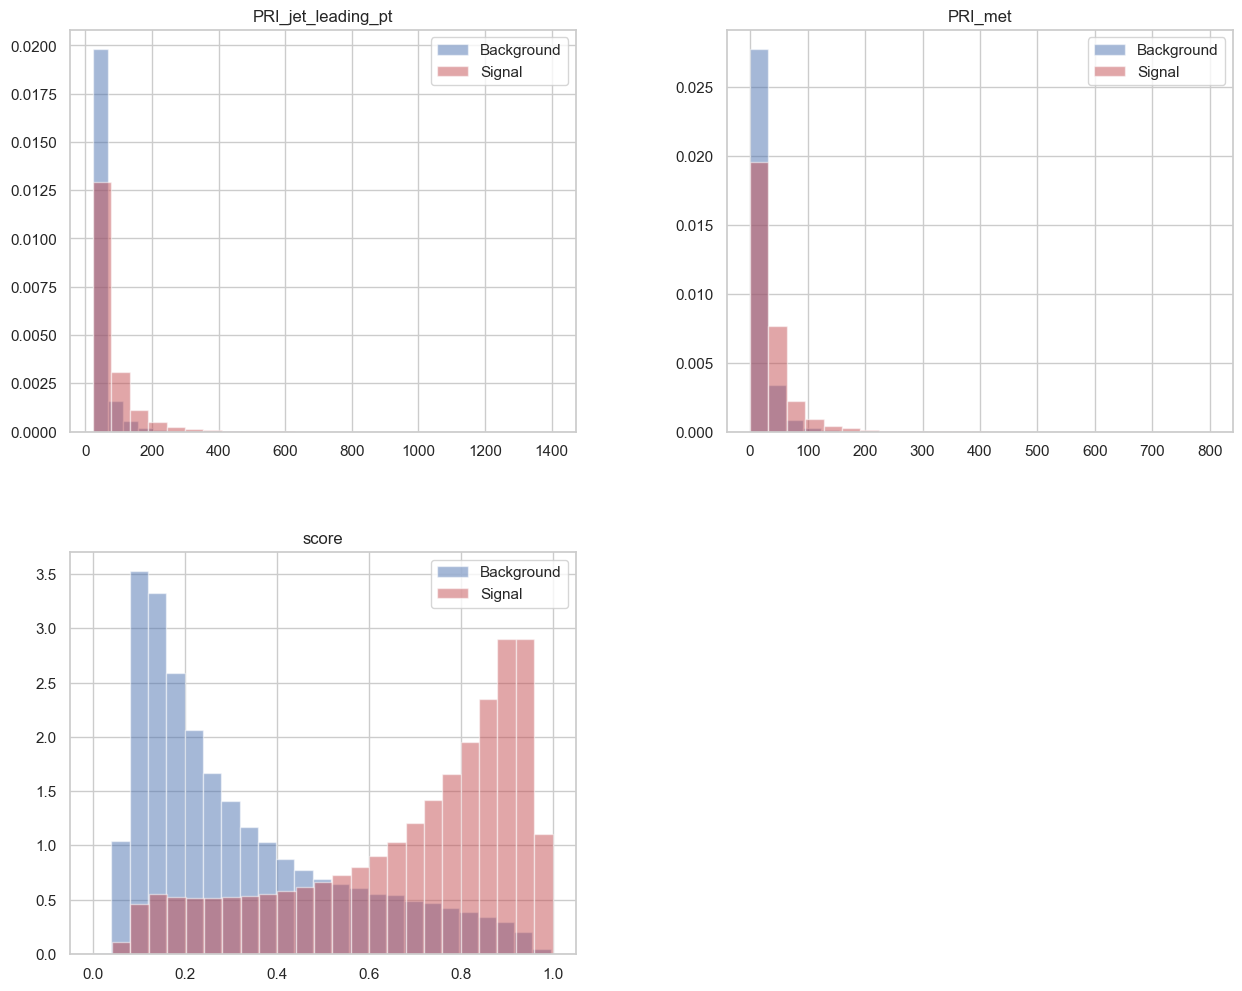

diboson (44079,)
diboson (44079,)
htautau (30,)
ttbar (56469,)
ttbar (56469,)
ztautau (156155,)
ztautau (156155,)


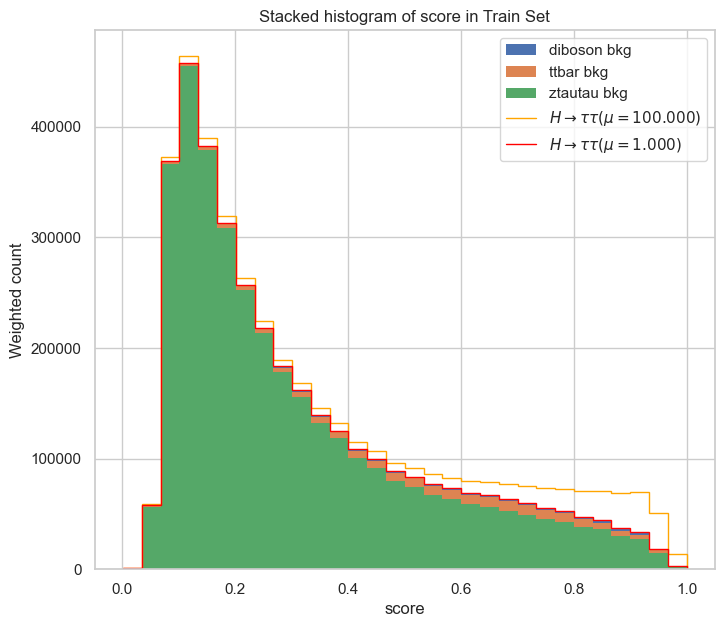

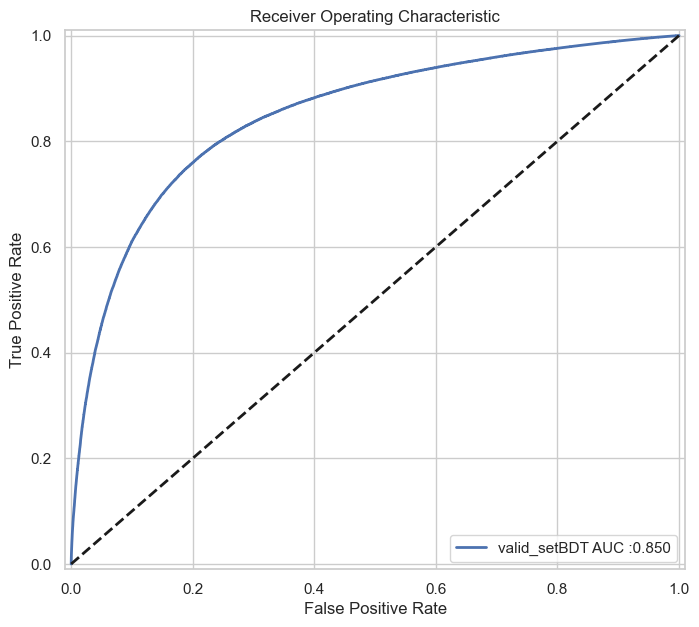

In [ ]:

# fit submission
ingestion.fit_submission()

In [ ]:

# load test set
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


In [ ]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
Test Results:  {'mu_hat': -2.934557641492783, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2934557641492783, 'del_mu_tot': 0.1467333854752644}
Test Results:  {'mu_hat': -2.941967136961343, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2941967136961343, 'del_mu_tot': 0.14710384638861293}
Test Results:  {'mu_hat': -2.941967136961343, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2941967136961343, 'del_mu_tot': 0.14710384638861293}
Test Results:  {'mu_hat': -2.941967136961343, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2941967136961343, 'del_mu_tot': 0.14710384638861293}
Test Results:  {'mu_hat': -2.941967136961343, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2941967136961343, 'del_mu_tot': 0.14710384638861293}
Test Results:  {'mu_hat': -2.934557641492783, 'del_mu_stat': 0.0025416804860736797, 'del_mu_sys': 0.2934557641492783, 'del_mu_tot': 0.1467333854752644}
Test Results:  {'mu_hat': -2.934557641

In [ ]:
ingestion.compute_result()

[*] Saving ingestion result


In [ ]:

# save result
ingestion.save_result(output_dir)

## Score
1. Compute Scores
2. Visualize Scores


In [ ]:
from HiggsML.score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
print(output_dir)
score.load_ingestion_results(prediction_dir = output_dir, score_dir = output_dir)

/home/chakkappai/Work/ST4_CS/Collaboration_D/sample_result_submission
[*] Reading predictions
[✔]


[*] Computing scores
[*] mu_hats: {'mu_hats': [-2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783, -2.934557641492783], 'delta_mu_hats': [0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644, 0.1467333854752644], 'p16': [-3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476, -3.0812910269680476], 'p84': [-2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519, -2.787824256017519]}
------------------
Set 0
------------------
MAE (avg): 7.2674537718713434
RMSE (avg): 14.212977036877394


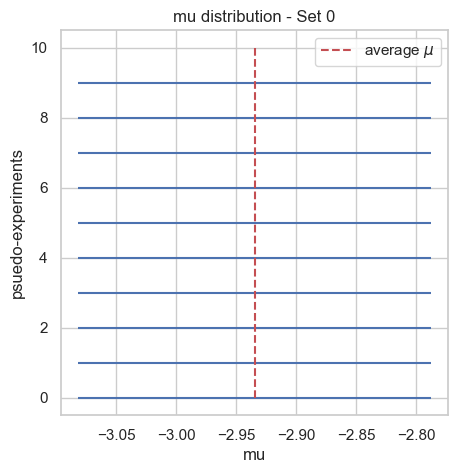

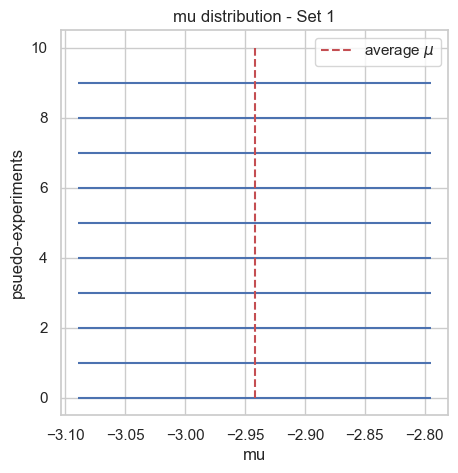

In [ ]:
# Compute Score
score.compute_scores(test_settings)

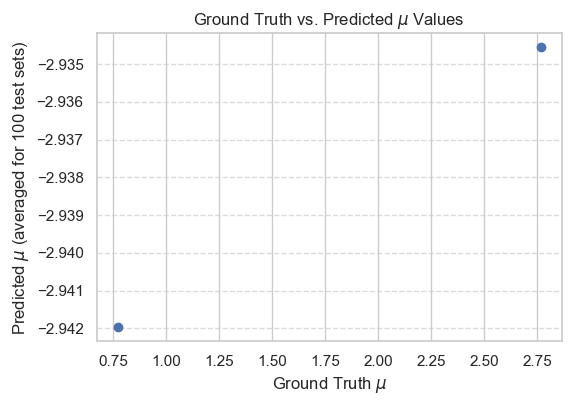

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualization.visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

## Submissions

In [ ]:
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing
# -------------------------------------
# Zip files
# -------------------------------------
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

### **Prepare the submission**

In [ ]:
import datetime
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'BlackSwan-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")


Submit : BlackSwan-code_submission_24-06-02-20-52.zip to the competition
